# Analyze consensus motif
The third output from the computational pipeline is a fasta file of the best predicted promoter for each input sequence. For more details about how robust these predictions are, see Section 2 of `inspect_BioProspector_results.ipynb`. 

Given a fasta file of best predictions from a given set of input settings for the pipeline, we next want to 
1. Visualize the consensus motif
1. Analyze occurences of the consensus motif across the genome

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import genbank_utils as gu
import consensus_viz_utils as cu



# load genome and features from Genbank

In [2]:
# from Bio import SeqIO, SeqFeature
# from Bio.SeqRecord import SeqRecord


# # genbank files
# gbFile_5G = 'data/5GB1c_sequence.gb'
# gb_5G = SeqIO.parse(gbFile_5G, "genbank").__next__()
# feat2meta = gu.get_feat2meta_dict(gbFile_5G)

# print("___ 5G ____")
# print("Genome length:", len(gb_5G.seq), "bps")
# print("num features:", len(gb_5G.features))
# print("num CDS features:", len([x for x in gb_5G.features if x.type=='CDS']))
# print("num gene features:", len([x for x in gb_5G.features if x.type=='gene']))
# print("num other features:", len([x for x in gb_5G.features if x.type not in ['gene', 'CDS']]))

# GENOME = gb_5G.seq
# GENOME_REV = gb_5G.seq.reverse_complement()
# GENOME_LEN = len(gb_5G.seq)
# print(GENOME[:10])
# print(GENOME_REV[-10:])

In [3]:
gbFile_5G = 'data/5GB1c_sequence.gb'

gfwd, grev,glen = gu.get_genome_fwd_rev_len(gbFile_5G)
print("Genome length:", glen, "bps")
print(gfwd[:10])
print(grev[-10:])


Genome length: 4998879 bps
ATGAGTGCAC
GTGCACTCAT


In [4]:
pos_feat_coords, neg_feat_coords = gu.get_pos_neg_relative_feature_coords(gbFile_5G, glen)

In [5]:
pos_dist_array,pos_nearest_feat_array = cu.build_feature_distance_index(pos_feat_coords,glen)
neg_dist_array,neg_nearest_feat_array = cu.build_feature_distance_index(neg_feat_coords,glen)

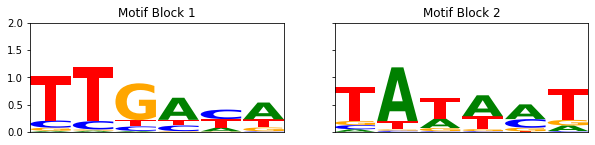

In [6]:
# Load BioPropsector output
selection_f = "n3_outdir/loci_in_top_3perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952202_SELECTION.fa"
motif_blocks, m1, m2 = cu.build_2Bmotif_from_selection_file(selection_f)

### Determine how well each promoter prediction scores against this consensus 

In [7]:
hex_score_df = cu.score_predictions_to_motif(motif_blocks, m1, m2, 3)

In [8]:
scatter = alt.Chart(
    hex_score_df,
    #title=f"Prediction consensus matches"
).mark_point().encode(
    x=alt.X('hex1_score:Q',axis=alt.Axis(title="-35 Consensus Match")),
    y=alt.Y('hex2_score:Q',axis=alt.Axis(title="-10 Consensus Match")),
    color=alt.Color('total_score:Q',scale=alt.Scale(scheme='viridis'),sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
).properties(
    width=200,
    height=200
)

stripplot = alt.Chart(
    hex_score_df,
    #title=f"Prediction consensus matches"
).mark_point().encode(
    x=alt.X(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
        scale=alt.Scale()
    ),
    y=alt.Y('total_score:Q',axis=alt.Axis(title="Total Consensus Score")),
    color=alt.Color('total_score:Q',scale=alt.Scale(scheme='viridis'),sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
    column=alt.Column(
        'nperc:N',
        header=alt.Header(
            labelFontSize=16,
            labelAngle=0,
            titleOrient='top',
            labelOrient='bottom',
            labelAlign='center',
            labelPadding=25,
        ),
    ),
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
# ).configure_facet(
#     spacing=0
# ).configure_view(
#     stroke=None
# ).configure_axis(
#     labelFontSize=16,
#     titleFontSize=16
).properties(height=200, width=100)

combo = alt.hconcat(
    scatter, 
    stripplot,
    title=f"Prediction consensus matches"
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_axis(
    labelFontSize=16,
    titleFontSize=16,
).configure_title(
    #align='center',
    anchor='middle',
    fontSize=20
)

In [9]:
combo


alt.HConcatChart(...)

# Search for the consensus across the genome

Adding categories to pssm matches...
Normalizing pssm match counts


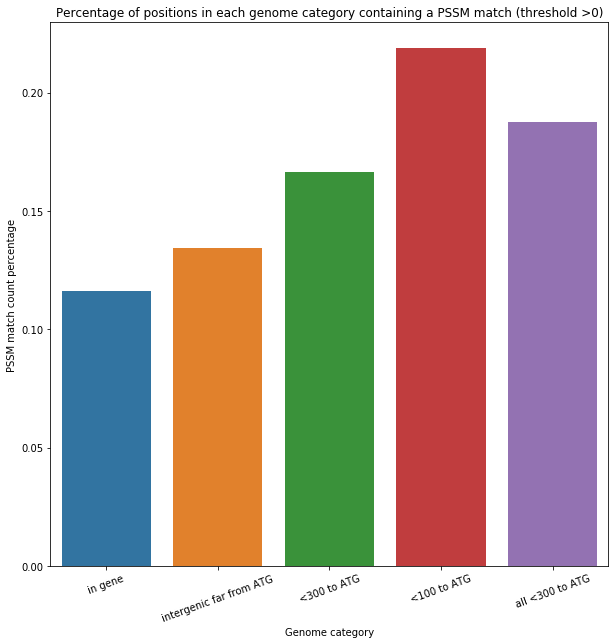

Normalizing filtered match counts...


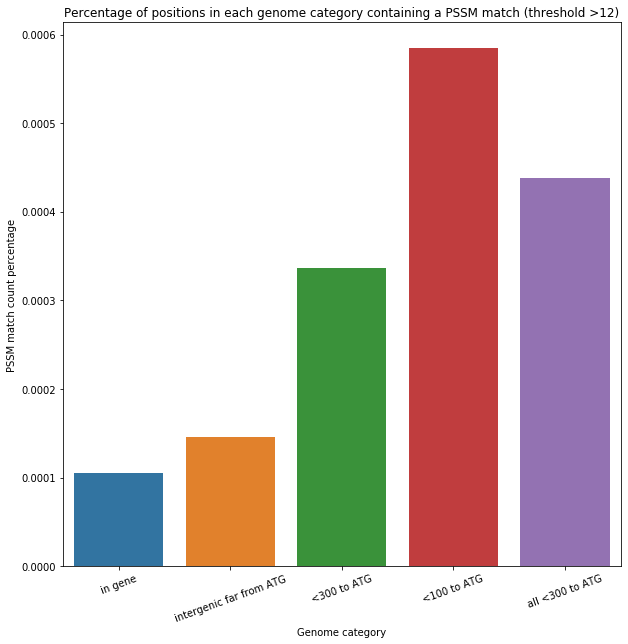

done!


In [10]:
genomes = [
    ('genome_fwd','genome_fwd',gfwd),
    ('genome_rev','genome_rev',grev)
]

# build variably spaced motifs
var_spaced_motifs = cu.build_dict_of_motifs_to_try(m1, m2)

whole_genome_motif_match_df = cu.find_and_score_motifs_in_seqs(var_spaced_motifs,genomes,{})

cu.analyze_motif_matches_across_genome(whole_genome_motif_match_df,
                                    pos_dist_array,
                                    pos_nearest_feat_array,
                                    neg_dist_array,
                                    neg_nearest_feat_array
                                    )